In [354]:
from s04utils.modules.load import timestamps

from bokeh.plotting import figure, show, output_notebook, curdoc
from IPython.core.display import set_matplotlib_formats

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sfHMM import sfHMM1
from pybaselines import Baseline

In [355]:
# Set the path to the data

# 'step-like' shape
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/20uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_20uW_77K_circpol_002.h5'
timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/10uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_10uW_77K_circpol_020.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_019.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_25/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_015.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_09/77K-33nM-eGFP-vitrified/10uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_10uW_77K_circpol_013.h5'

# 'burst-like' shape
timestamps_path_02 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_012.h5'

In [356]:
# Load timestamps from file

# Timestamps file 01
ts_01 = timestamps.load_from_path(path=timestamps_path_01)

# Timestamps file 02
ts_02 = timestamps.load_from_path(path=timestamps_path_02)

In [357]:
# Set bin time in seconds
bin_time = 0.01

# Create binned timetrace
timetrace01 = ts_01.get_timetrace_data(bin_width=bin_time)

# Get the binned timetrace data for each individual detector
detector0 = timetrace01['detector0'][0]
detector1 = timetrace01['detector1'][0]

# Create a pandas dataframe
df0 = pd.DataFrame({'detector0': detector0})
df1 = pd.DataFrame({'detector1': detector1})

# save the dataframe to a csv file without the index
df0.to_csv('timetrace0.csv', index=False, header=False)
df1.to_csv('timetrace1.csv', index=False, header=False)


In [358]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

/var/folders/2h/6xcys3mx1s7czfj28g_dc70r0000gn/T/ipykernel_18504/3784220441.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Loading BokehJS ...

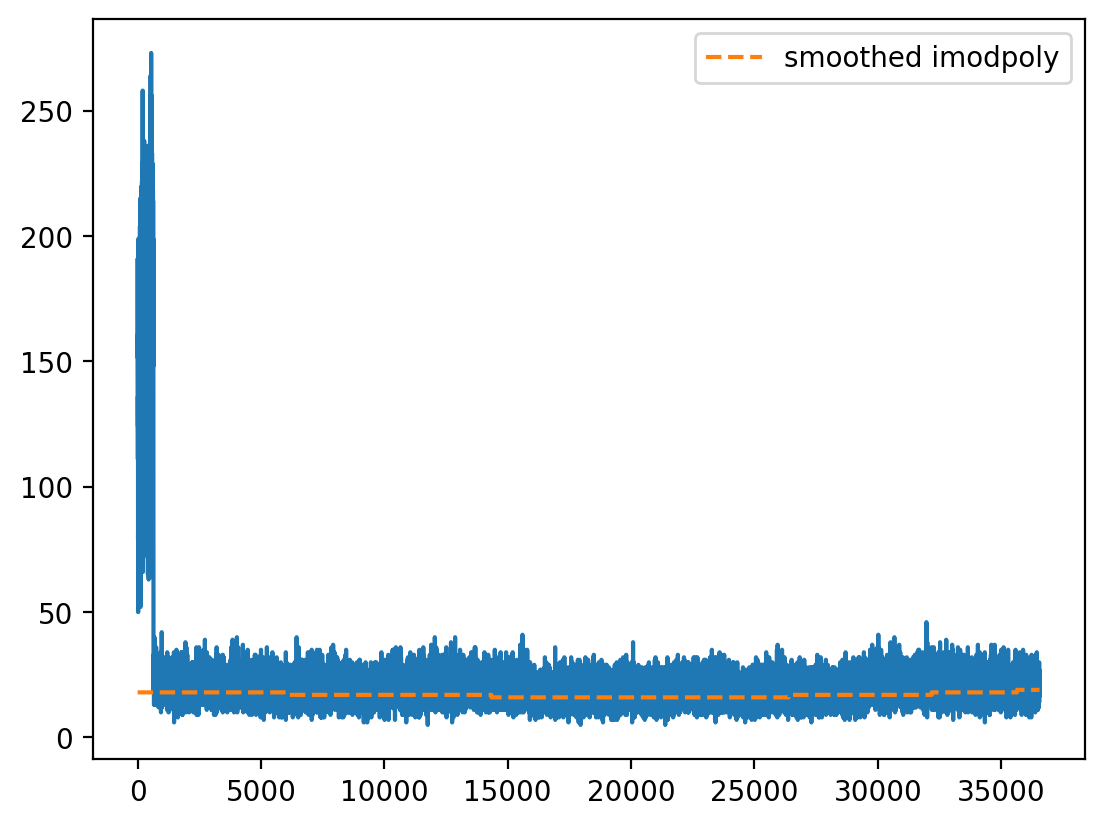

In [359]:
x_data = np.linspace(0, len(detector1), len(detector1))
y_data0 = detector0
y_data1 = detector1

baseline_fitter = Baseline(x_data=x_data)

smoothed_imodpoly0 = baseline_fitter.imodpoly(y_data0, poly_order=3, num_std=0.7)[0]
smoothed_imodpoly1 = baseline_fitter.imodpoly(y_data1, poly_order=3, num_std=0.7)[0]

plt.figure()
plt.plot(y_data1)
#plt.plot(regular_imodpoly, label='imodpoly')
plt.plot(smoothed_imodpoly1, '--', label='smoothed imodpoly')
#plt.plot(baseline, ':', label='true baseline')
plt.legend()

plt.show()

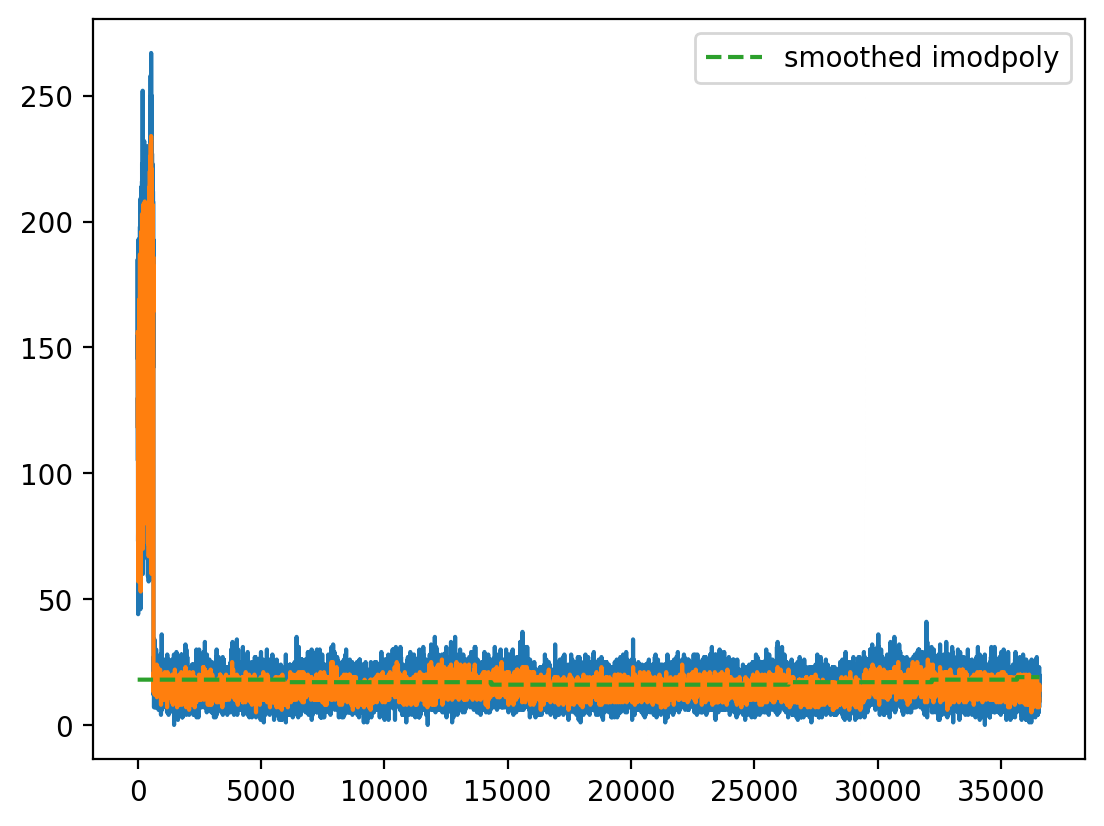

In [360]:
# Subtract the baseline from the data
y_data_corrected0 = y_data0 - smoothed_imodpoly0
y_data_corrected1 = y_data1 - smoothed_imodpoly1

# shift the data to positive values
y_data_corrected0 = y_data_corrected0 + np.abs(np.min(y_data_corrected0))
y_data_corrected1 = y_data_corrected1 + np.abs(np.min(y_data_corrected1))

# smooth the data with a rolling median filter
y_data_smoothed = pd.Series(y_data_corrected1).rolling(5, center=True).median()

# Plot the corrected data
plt.figure()
plt.plot(y_data_corrected1)
plt.plot(y_data_smoothed, '-')
plt.plot(smoothed_imodpoly1, '--', label='smoothed imodpoly')
plt.legend()

plt.show()


In [361]:
# Create a pandas dataframe
df0 = pd.DataFrame({'detector0': y_data_corrected0})
df1 = pd.DataFrame({'detector1': y_data_corrected1})

# save the dataframe to a csv file without the index
df0.to_csv('timetrace0.csv', index=False, header=False)
df1.to_csv('timetrace1.csv', index=False, header=False)

df0.head()
df1.head()

,detector1
0,146
1,185
2,168
3,156
4,142


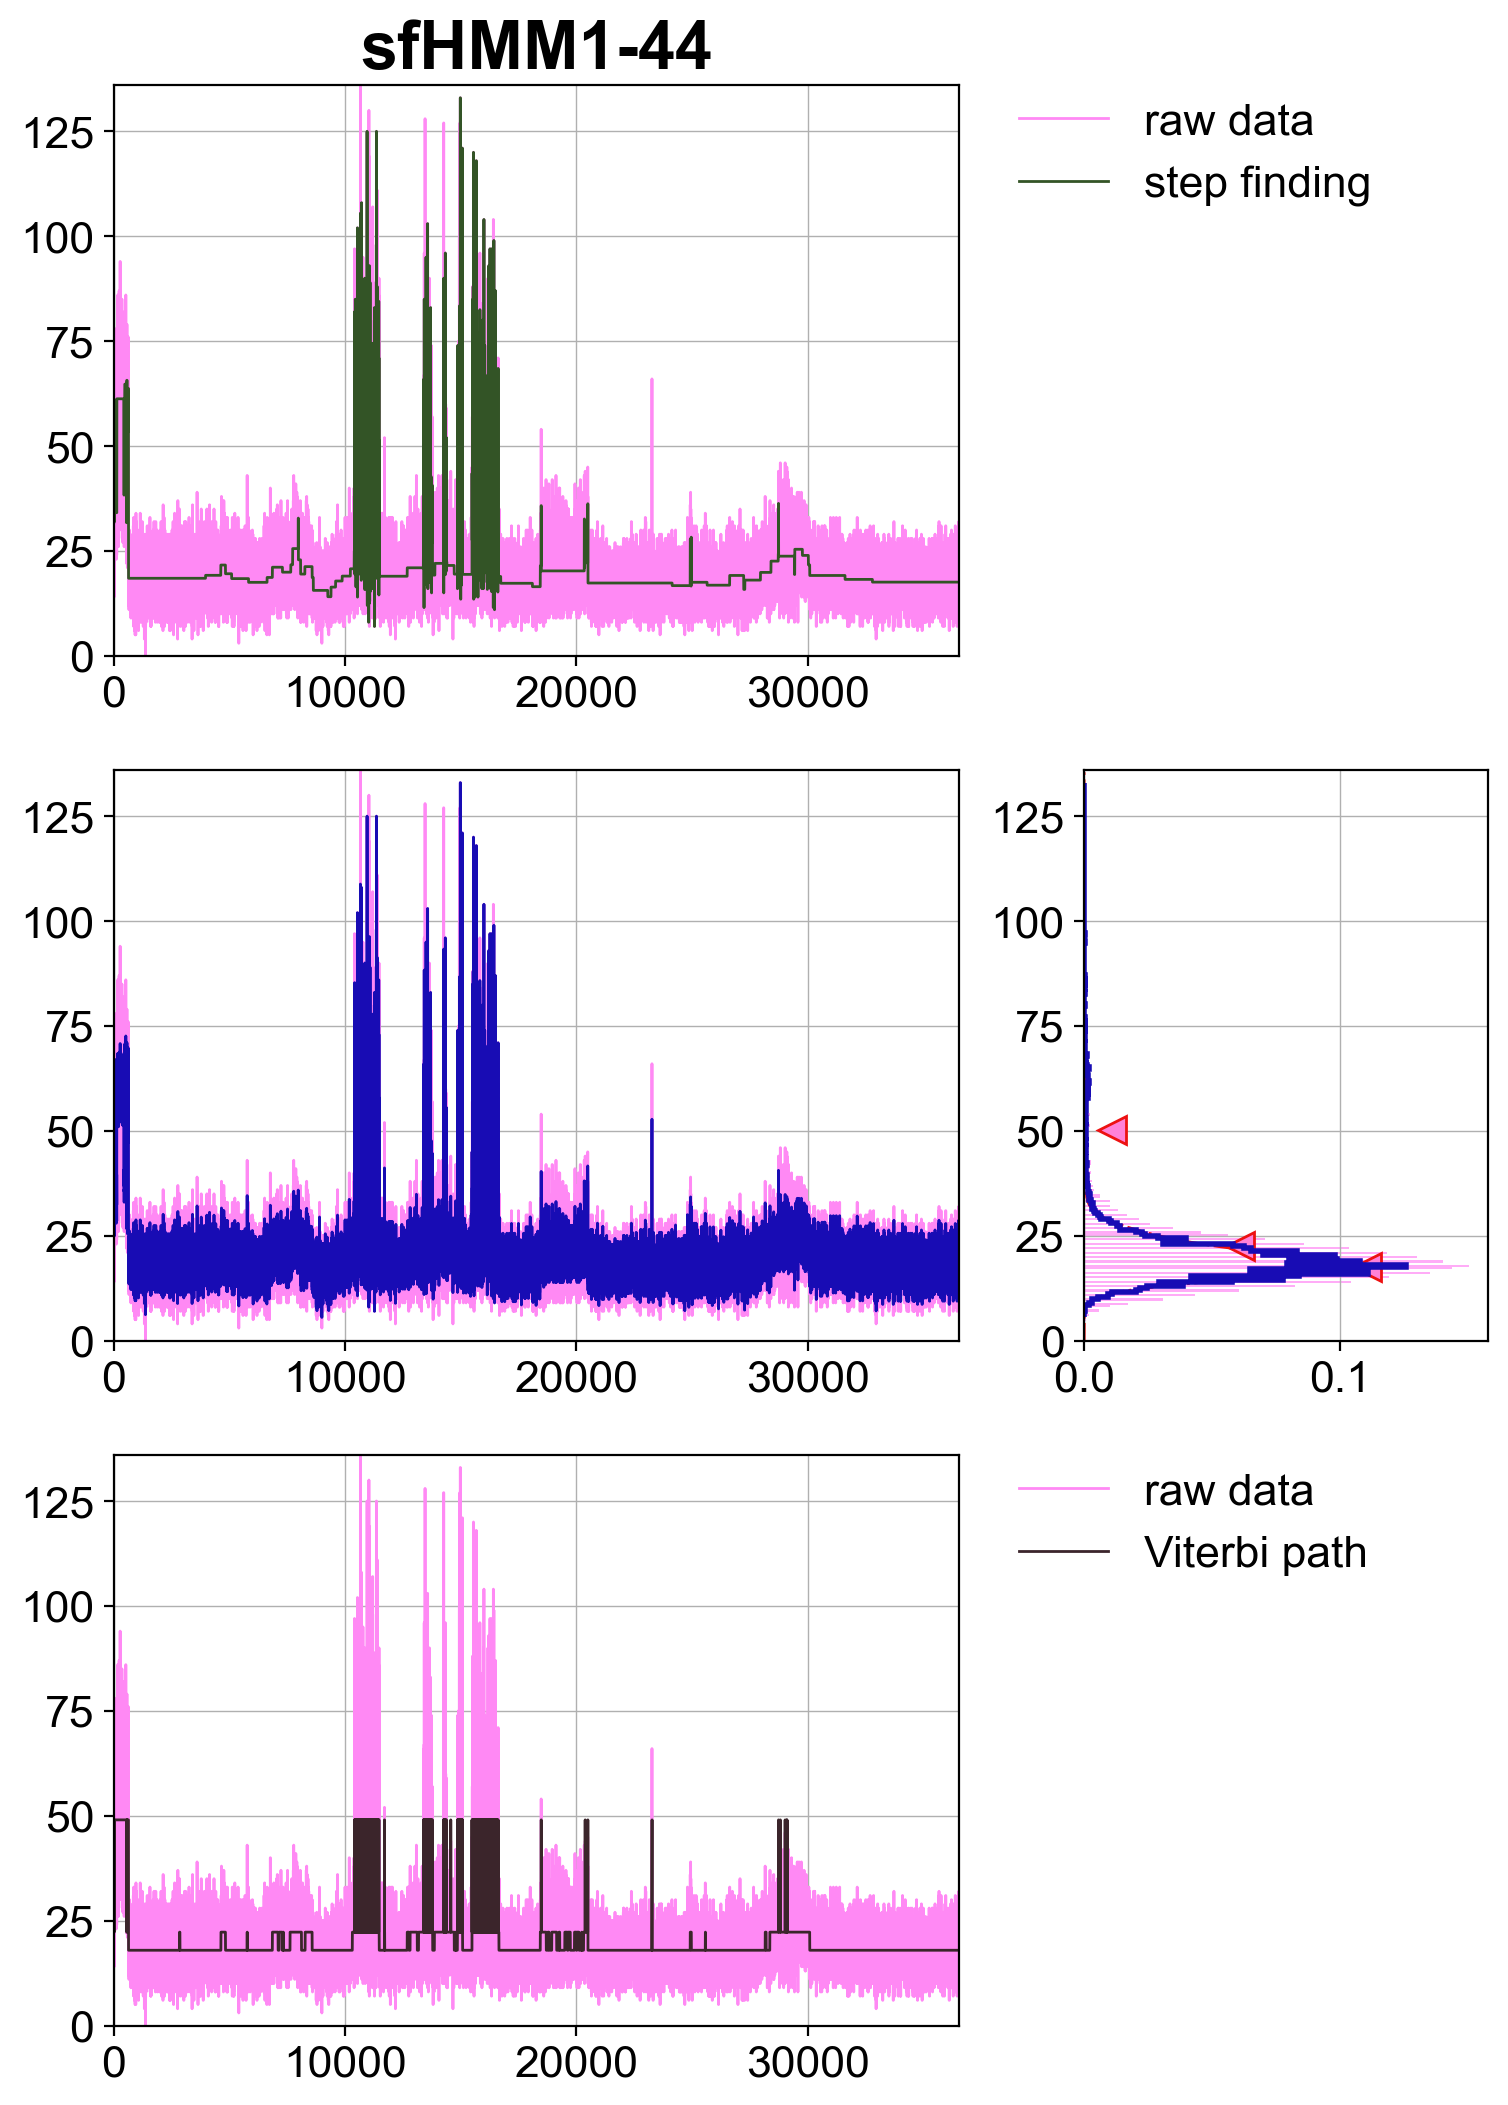

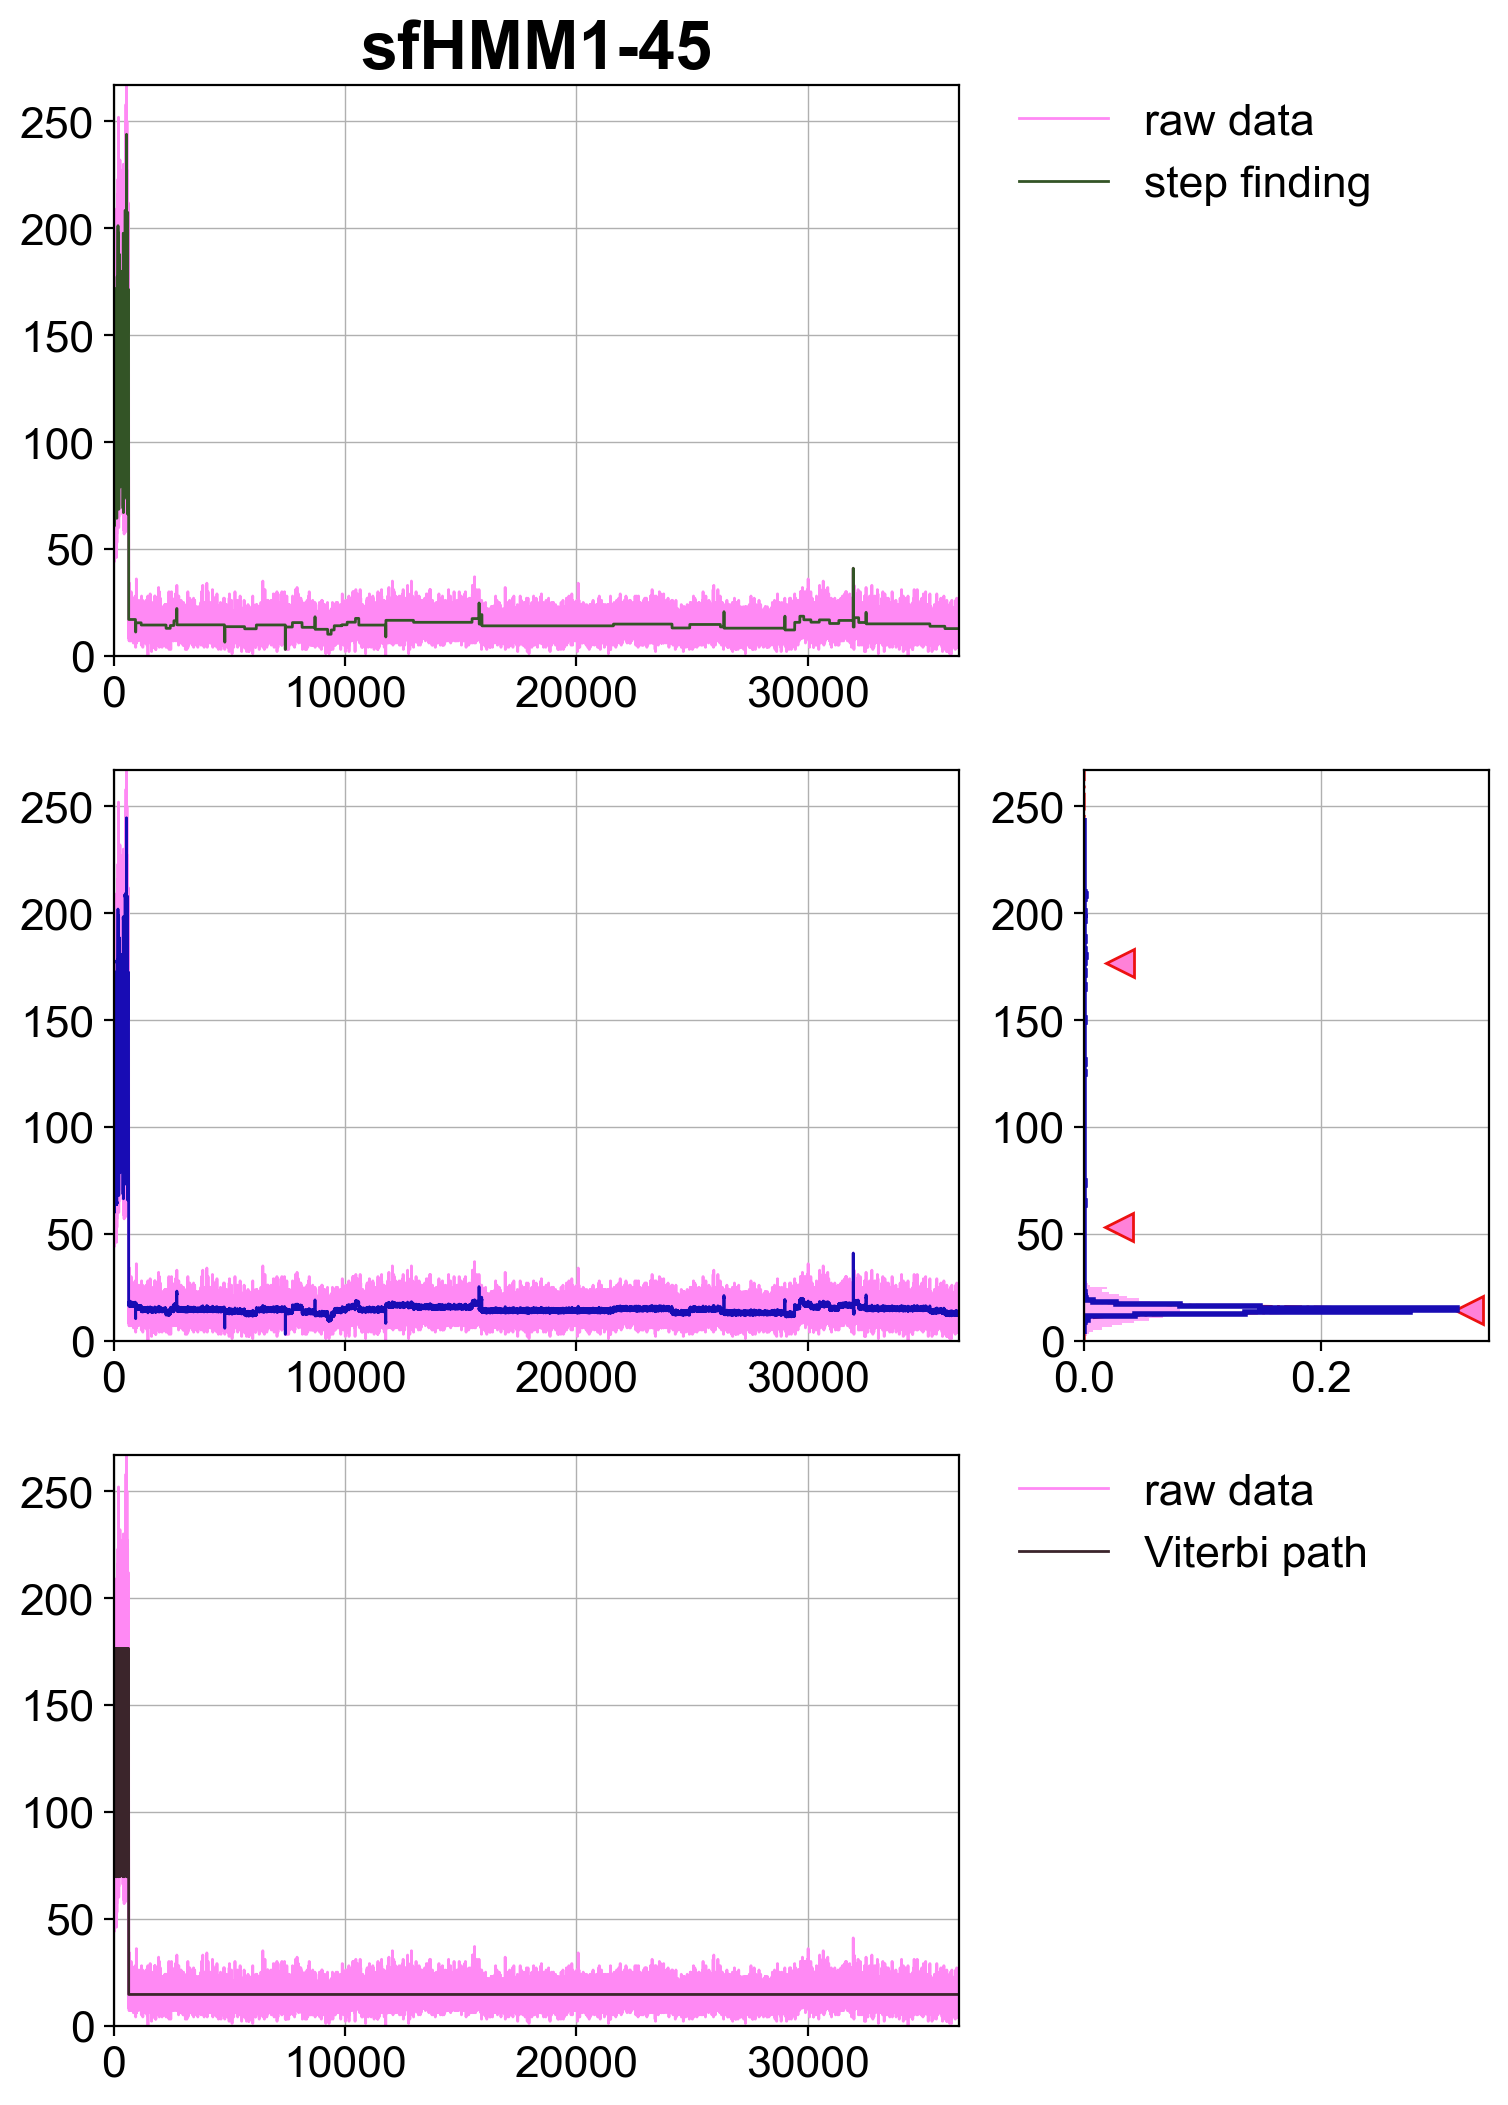

In [362]:
csv_path0 = '/Users/kappel/Documents/Programming/python-projects/s04-data-analysis/on-off-times/timetrace0.csv'
csv_path1 = '/Users/kappel/Documents/Programming/python-projects/s04-data-analysis/on-off-times/timetrace1.csv'
data0 = pd.read_csv(csv_path0, header=None, index_col=False)
data1 = pd.read_csv(csv_path1, header=None, index_col=False)

# delete datapoints from 2000 inwards
#data = data.drop(data.index[12000:])
sf0 = sfHMM1(data0, krange=(2,3), model='p').run_all()
sf1 = sfHMM1(data1, krange=(2,3), model='p').run_all()

In [363]:
'''plt.plot(sf0.data_raw, color="lightgray")
plt.plot(sf0.data_fil, color="gray")
plt.plot(sf0.step.fit, color="gold")
plt.plot(sf0.viterbi, color="red")
plt.legend(["raw data", "filtered data", "step fit", "viterbi"])
plt.xlim(6000, 6350)
plt.show()'''

# create the same plot with bokeh
p = figure(width=1500, height=600, title="on-off-sfHMM")
p.line(x=np.arange(len(sf0.data_raw)), y=sf0.data_raw, color="lightgray", legend_label="raw data0")
p.line(x=np.arange(len(sf1.data_raw)), y=sf1.data_raw, color="gray", legend_label="raw data1")
#p.line(x=np.arange(len(sf0.data_fil)), y=sf0.data_fil, color="gray", legend_label="filtered data")
#p.line(x=np.arange(len(sf0.step.fit)), y=sf0.step.fit, color="gold", legend_label="step fit")
p.line(x=np.arange(len(sf0.viterbi)), y=sf0.viterbi, color="red", legend_label="viterbi0", line_width=2)
p.line(x=np.arange(len(sf1.viterbi)), y=sf1.viterbi, color="green", legend_label="viterbi1",line_width=2)
p.legend.location = "top_left"
show(p)

In [364]:
# print unique values of the viterbi path
print(np.unique(sf0.viterbi))

# calculate step sizes
first_step_size0 = np.unique(sf0.viterbi)[1] - np.unique(sf0.viterbi)[0]
second_step_size0 = np.unique(sf0.viterbi)[2] - np.unique(sf0.viterbi)[1]
print(first_step_size0)
print(second_step_size0)

print(np.unique(sf1.viterbi))

# calculate step sizes
first_step_size1 = np.unique(sf1.viterbi)[1] - np.unique(sf1.viterbi)[0]
second_step_size1 = np.unique(sf1.viterbi)[2] - np.unique(sf1.viterbi)[1]
print(first_step_size1)
print(second_step_size1)



[17.94515041 22.26176084 49.01329552]
4.3166104236139375
26.751534683727503
[ 14.54685279  69.6302865  176.43095816]
55.083433709618475
106.80067165438192


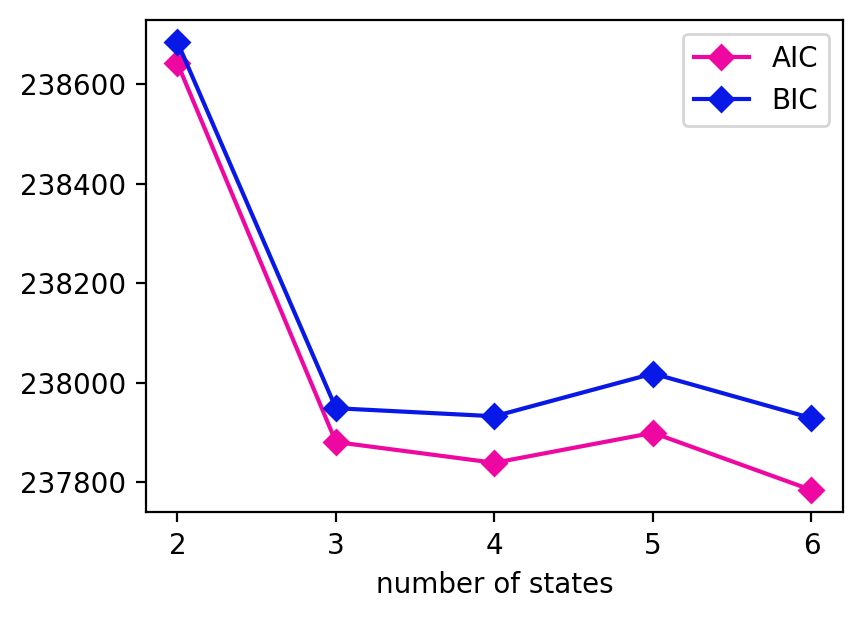

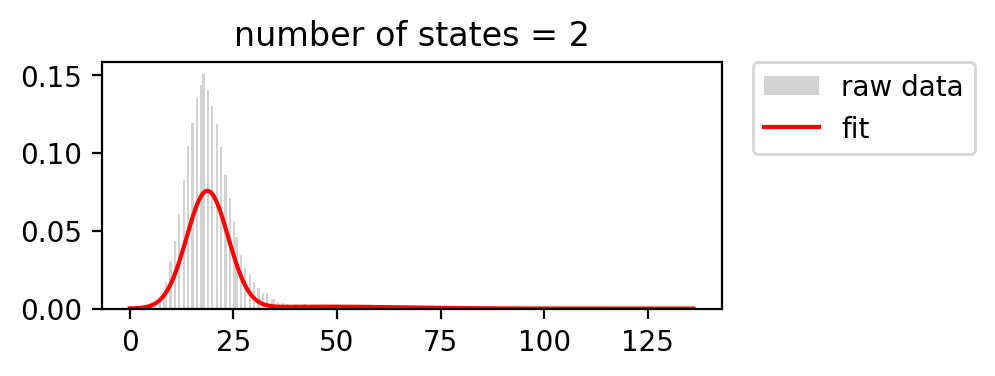

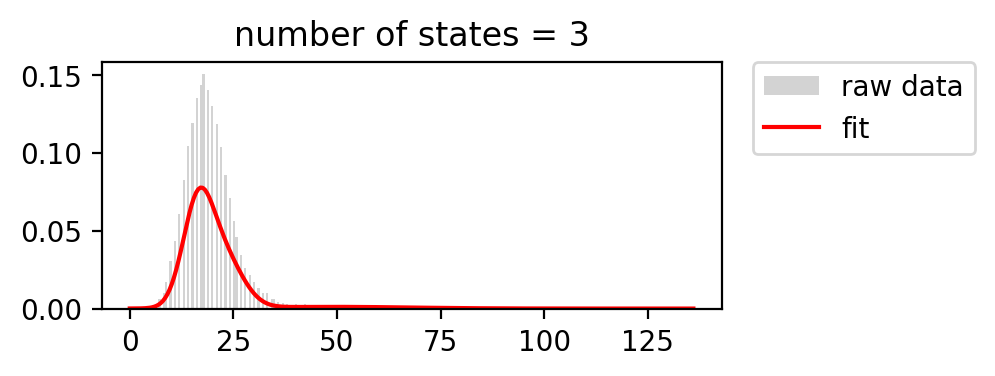

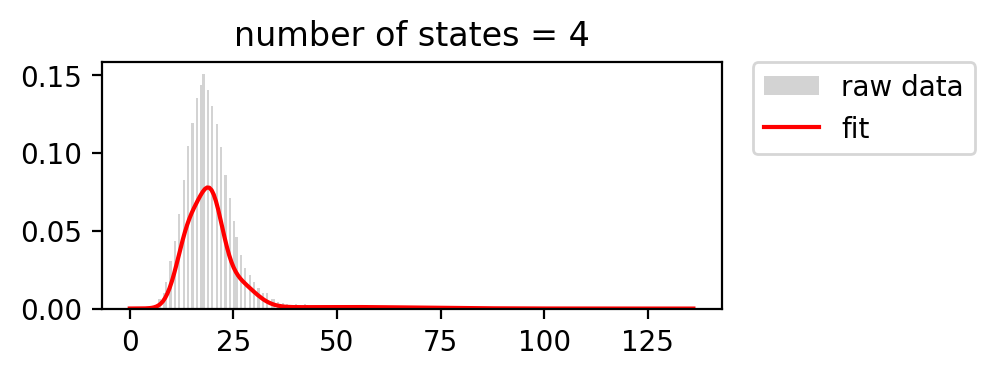

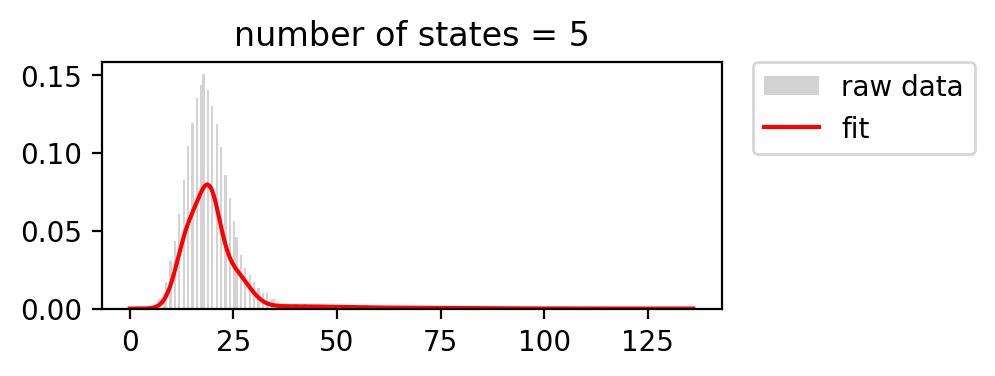

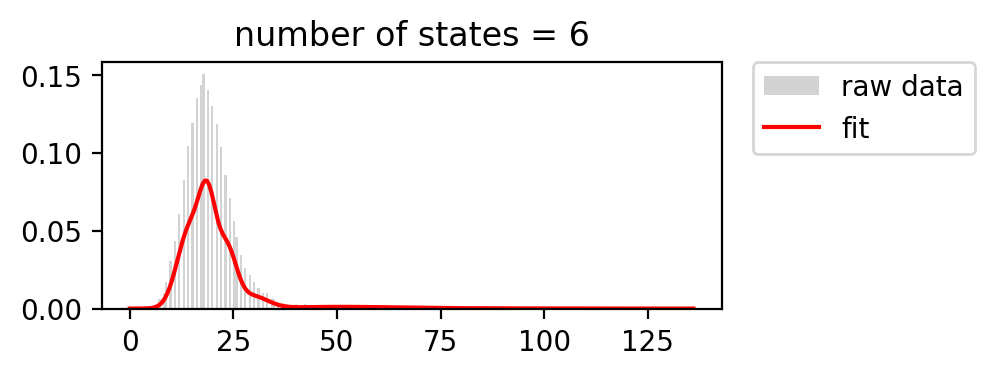

In [365]:
data = pd.read_csv(csv_path0, header=None, index_col=False)

from sfHMM.gmm import GMMs
gmms = GMMs(data, krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
gmms.plot_all()

In [366]:
# get the best model that minimizes BIC
gmm_optimal = gmms.get_optimal(criterion="bic")
print(gmm_optimal)
print("means =\n", gmm_optimal.means_)

GMM1(n_components=6)
means =
 [[14.20423142]
 [18.77087144]
 [23.51208334]
 [29.56280372]
 [50.09188879]
 [65.58132974]]


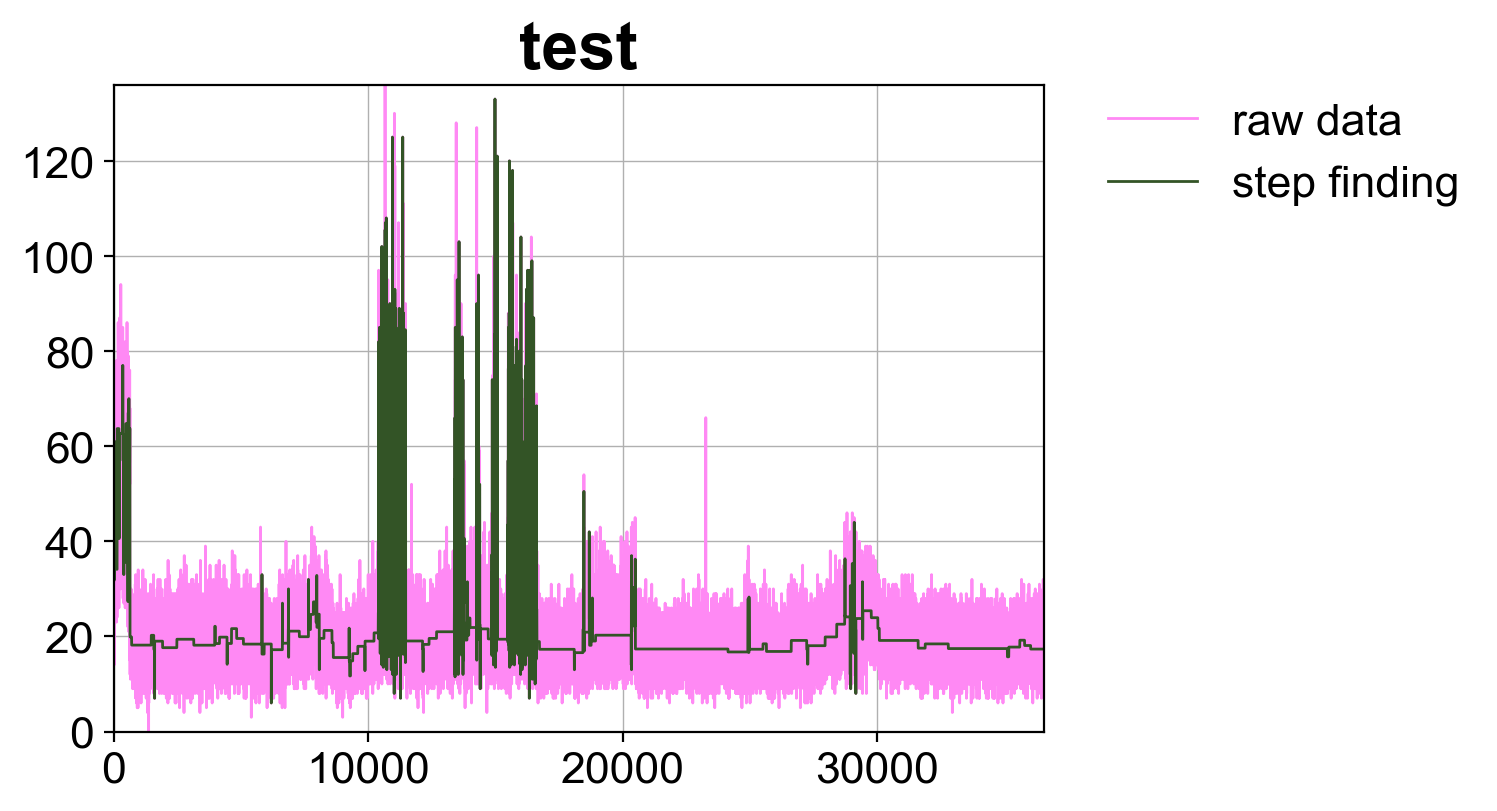

In [367]:
sf = sfHMM1(data, psf=0.03, name="test", model='p')

# 1. step finding
sf.step_finding()
sf.plot()

In [368]:
# 2. denoising
sf.denoising()

sfHMM1(model='PoissonStep', psf=0.03, sg0=2.988888888888889)

6


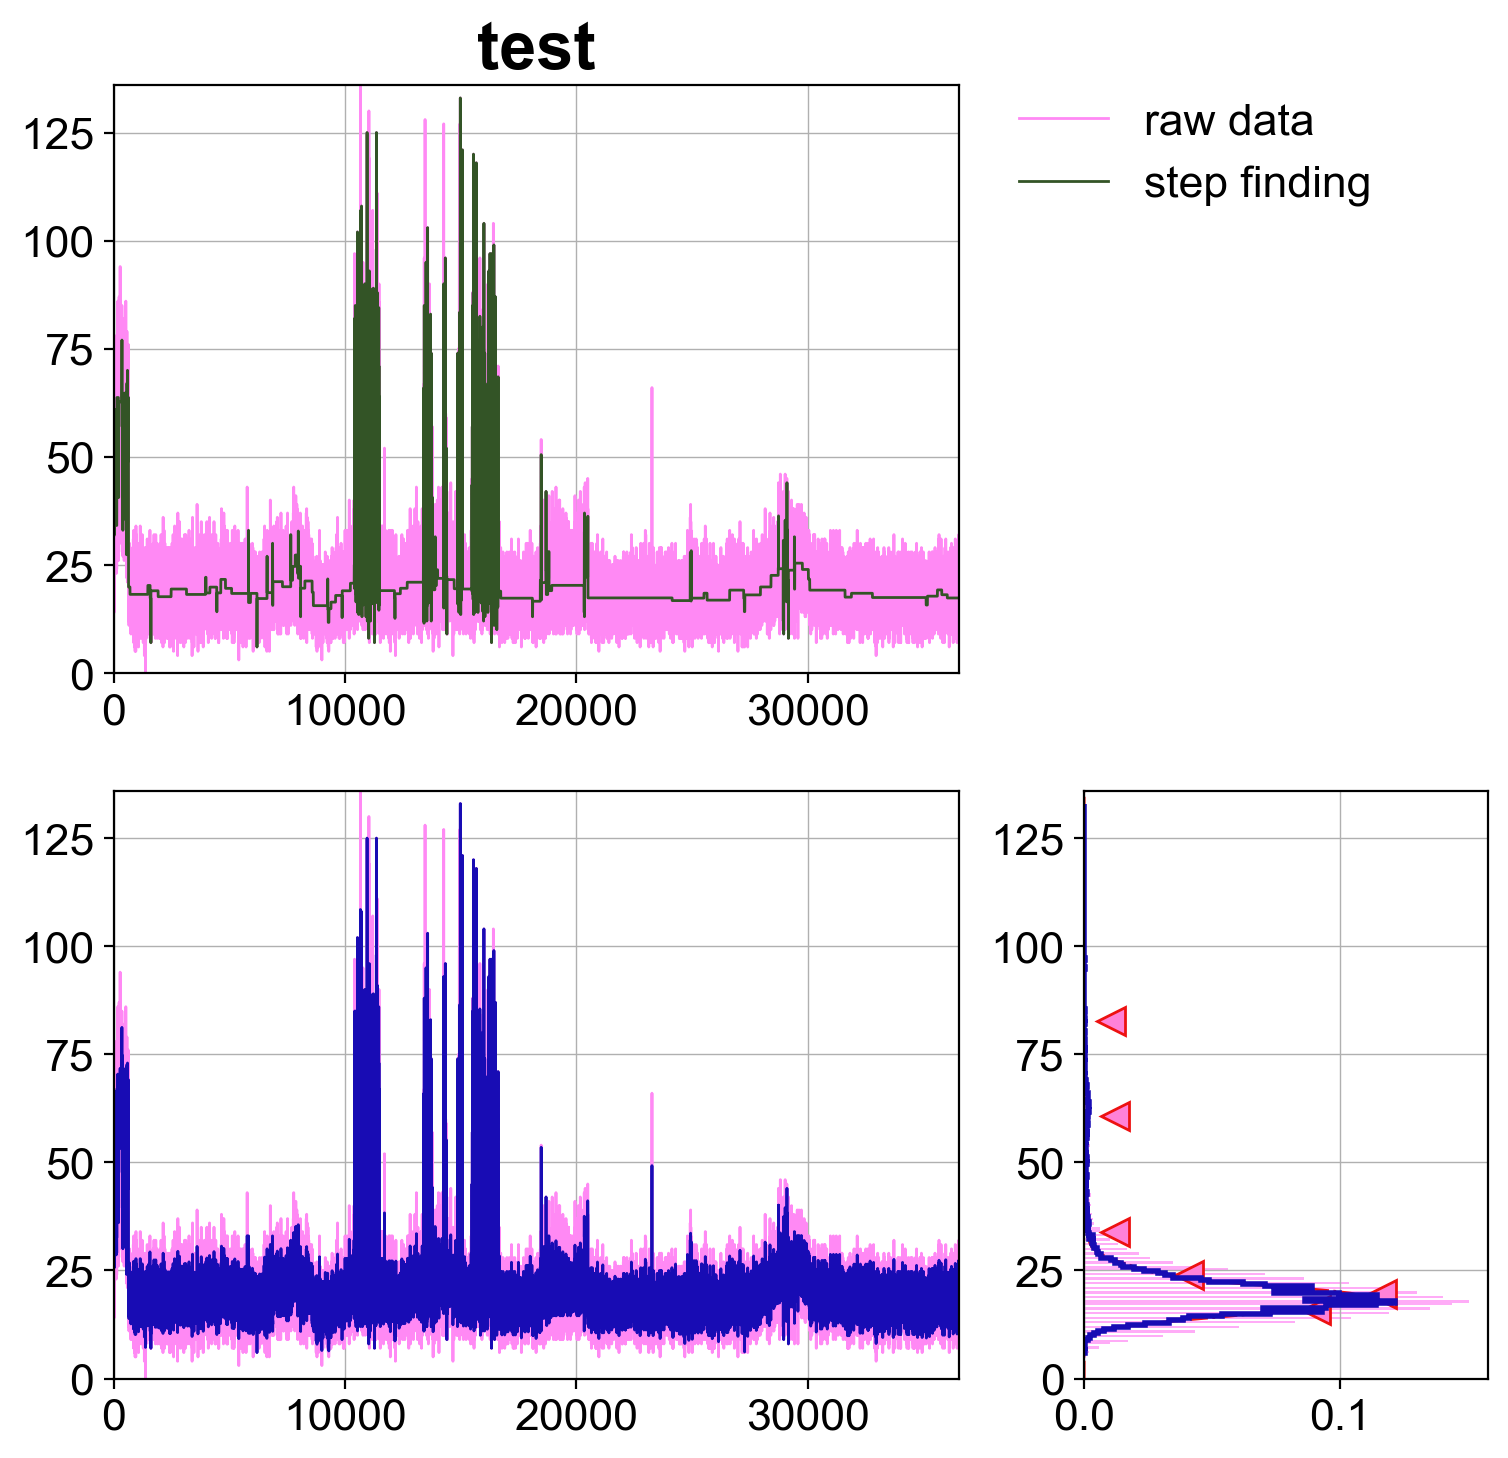

In [369]:
# 3. gmmfit
sf.gmmfit(n_init=2, method="bic")
print(sf.n_components)
sf.plot()

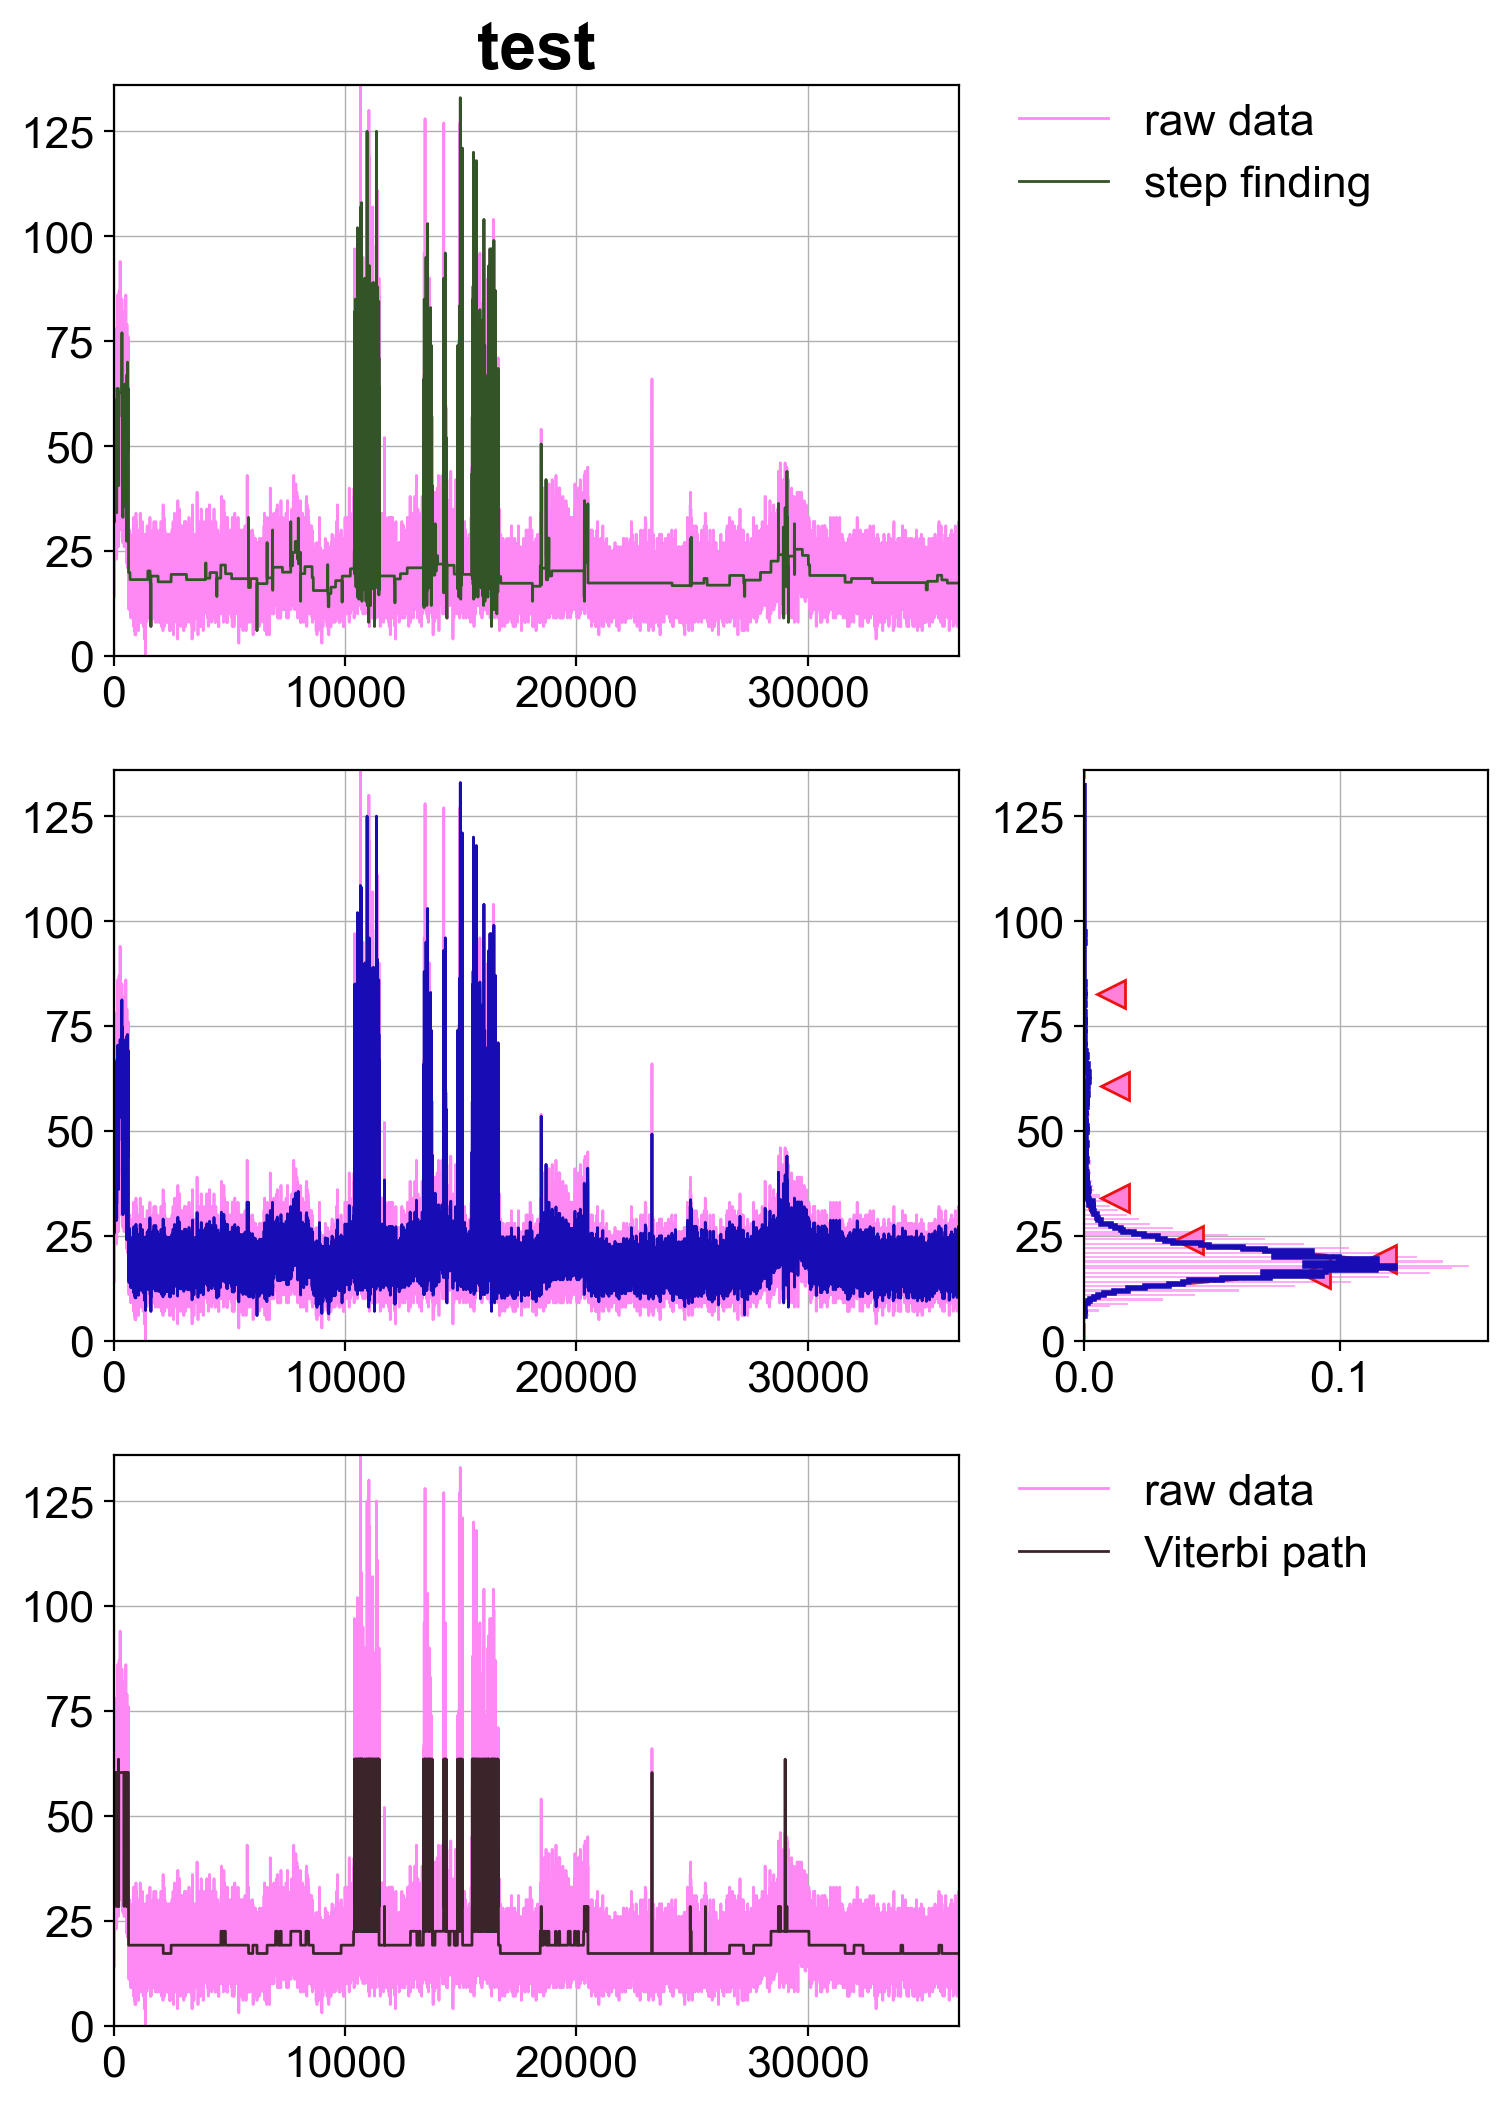

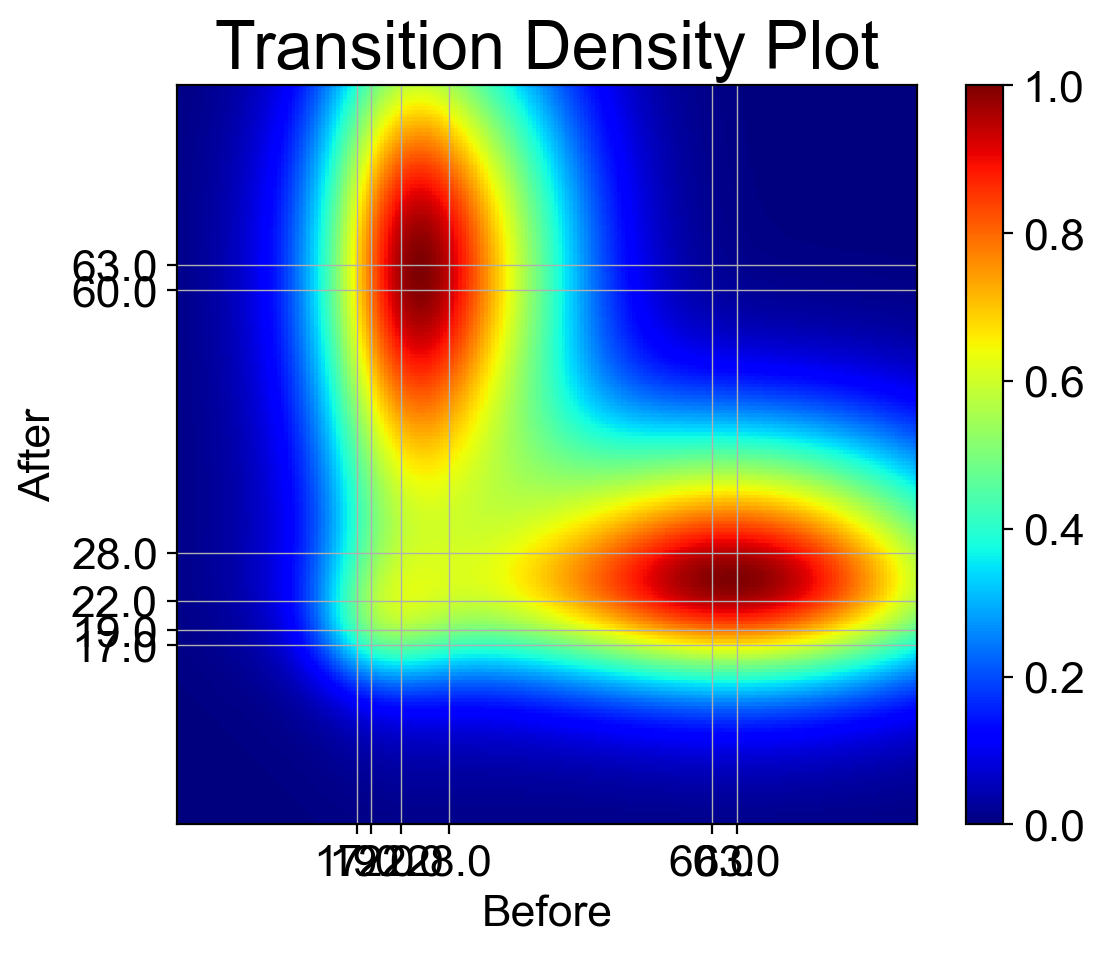

In [370]:
# 4. hmmfit
sf.hmmfit()
sf.plot()
sf.tdp()

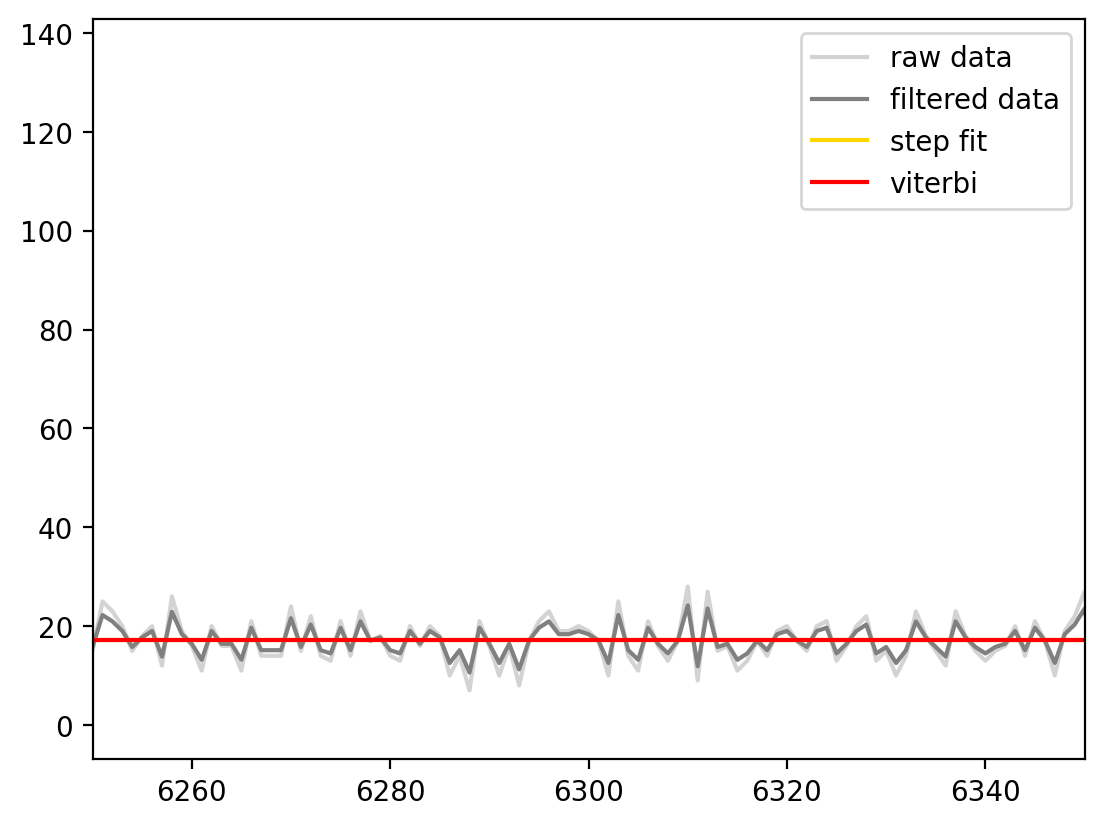

In [371]:
plt.plot(sf.data_raw, color="lightgray")
plt.plot(sf.data_fil, color="gray")
plt.plot(sf.step.fit, color="gold")
plt.plot(sf.viterbi, color="red")
plt.legend(["raw data", "filtered data", "step fit", "viterbi"])
plt.xlim(6250, 6350)
plt.show()

sf.sg0 =
 2.988888888888889
sf.n_components =
 6
sf.means_ =
 [[17.17392766]
 [19.15351894]
 [22.47044326]
 [28.39791122]
 [60.29740656]
 [63.48569309]]
sf.states =
 [4 4 4 ... 0 0 0]


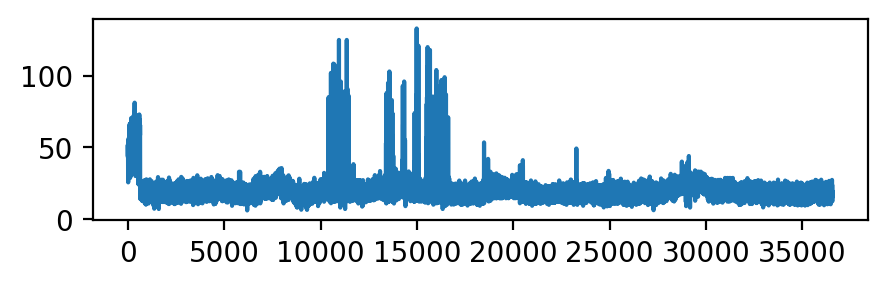

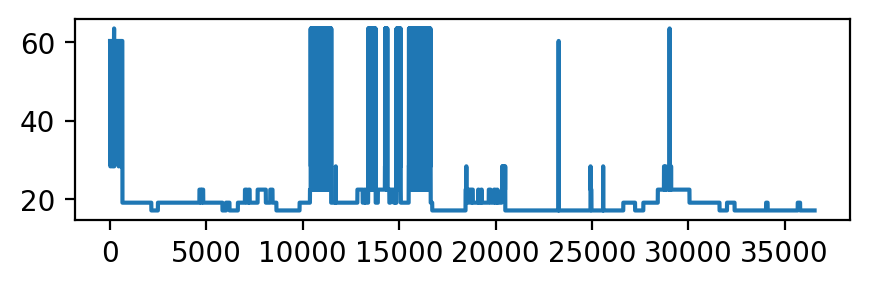

In [372]:
print("sf.sg0 =\n", sf.sg0)
print("sf.n_components =\n", sf.n_components)
print("sf.means_ =\n", sf.means_)
print("sf.states =\n", sf.states)
plt.figure(figsize=(5, 1.3))
plt.plot(sf.data_fil)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sf.viterbi)
plt.show()